# Regression Analysis

In this \[final] notebook, we perform regression analysis on our prepared dataset to identify features that have the largest impact on the next quoted price of a stock, following its earnings call. Our goal is to find any features supportive of a prediction based solely on the earnings call transcript.

Following our initial predictions, we add in the earnings surprise data to compare its impact with that of the earnings call transcript. Both sets of input data are available prior to the next open of the stock, so this is another valid feature for prediction.

### Evaluation Metric

The evaluation metric for this analysis is the volatility-adjusted change in the price of a stock. 

The metric for this, `vol_score`, is expressed as: `vol_score = (next_bar - prev_bar) / (vol10)`

Use of volatility-adjusted price change allows us to view every prediction as having equal weight, rather than allowing high-volatility stocks to dominate the analysis.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree

from category_encoders.cat_boost import CatBoostEncoder

import scipy
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import time
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
stock = pd.read_pickle('data/llm_complete.pkl.bz2')
stock

exchange        q ticker                date  tz  market_open  \
0       nasdaq  2020-Q2   bili 2020-08-27 21:00:00  ET        False   
1         nyse  2020-Q3    gff 2020-07-30 16:30:00  ET        False   
2       nasdaq  2020-Q1   lrcx 2019-10-23 17:00:00  ET        False   
4       nasdaq  2019-Q2   cste 2019-08-07 08:30:00  ET        False   
5         nyse  2020-Q3   gdot 2020-11-04 17:00:00  ET        False   
...        ...      ...    ...                 ...  ..          ...   
18745   nasdaq  2021-Q3   avxl 2021-08-12 16:30:00  ET        False   
18747   nasdaq  2023-Q2   nvda 2022-08-24 17:00:00  ET        False   
18749   nasdaq  2022-Q2     dh 2022-08-04 17:00:00  ET        False   
18753   nasdaq  2021-Q4   dvax 2022-02-28 16:30:00  ET        False   
18754     nyse  2021-Q2    cib 2021-08-12 09:00:00  ET        False   

      valid_bars     vol10     vol20    prev_bar  ...  negative_2_4  \
0           True  1.153000  1.201000   45.139999  ...      0.026667   
1           True  0.346000  0.402000   20.639999  ...      0.226415   
2           True  3.161005  3.300003  233.179993  ...      0.073171   
4           True  0.208000  0.183000   14.250000  ...      0.163265   
5           True  1.345000  1.224000   55.000000  ...      0.112069   
...          ...       ...       ...         ...  ...           ...   
18745       True  0.562000  0.711500   19.270000  ...      0.048387   
18747       True  0.430700  0.443600   17.222000  ...      0.116667   
18749       True  0.856000  0.661500   29.330000  ...      0.051546   
18753       True  0.380000  0.312000   12.260000  ...      0.112903   
18754       True  0.424000  0.370500   28.980000  ...      0.082474   

       neutral_2_4  sentiment_3_4  positive_3_4  negative_3_4  neutral_3_4  \
0         0.306667       0.467723      0.485294      0.000000     0.514706   
1         0.396226       0.157721      0.318841      0.028986     0.652174   
2         0.666667       0.087484      0.159664      0.050420     0.789916   
4         0.387755       0.041763      0.140000      0.060000     0.800000   
5         0.681034       0.062409      0.109489      0.014599     0.875912   
...            ...            ...           ...           ...          ...   
18745     0.838710       0.082376      0.127273      0.036364     0.836364   
18747     0.658333       0.047602      0.140845      0.084507     0.774648   
18749     0.329897       0.040662      0.289855      0.050725     0.659420   
18753     0.306452       0.055688      0.148936      0.010638     0.840426   
18754     0.505155       0.102146      0.257812      0.039062     0.703125   

       sentiment_4_4  positive_4_4  negative_4_4  neutral_4_4  
0           0.116051      0.324324      0.000000     0.675676  
1           0.119448      0.383562      0.041096     0.575342  
2           0.065251      0.161538      0.030769     0.807692  
4           0.079609      0.134615      0.038462     0.826923  
5           0.072067      0.186441      0.042373     0.771186  
...              ...           ...           ...          ...  
18745       0.056451      0.138462      0.030769     0.830769  
18747       0.050567      0.123077      0.092308     0.784615  
18749       0.069709      0.144000      0.016000     0.840000  
18753       0.086963      0.200000      0.066667     0.733333  
18754       0.152475      0.345794      0.018692     0.635514  

[11902 rows x 55 columns]

In [4]:
# final filtering before analysis

# remove stocks with na values in surprise_vol column
#stock = stock.query('surprise_vol.notna()')

# remove stocks with long lags between earnings release and earnings transcript
#stock = stock.query('abs(release_call_time_diff) < 24')
#stock = stock.query('abs(release_call_time_diff) <= 2') 
stock = stock.query('surprise_vol.notna()')
stock = stock.query('abs(release_call_time_diff) < 72')
stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11181 entries, 0 to 18754
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   exchange                11181 non-null  object        
 1   q                       11181 non-null  object        
 2   ticker                  11181 non-null  object        
 3   date                    11181 non-null  datetime64[ns]
 4   tz                      11181 non-null  object        
 5   market_open             11181 non-null  bool          
 6   valid_bars              11181 non-null  object        
 7   vol10                   11181 non-null  float64       
 8   vol20                   11181 non-null  float64       
 9   prev_bar                11181 non-null  float64       
 10  next_bar                11181 non-null  float64       
 11  pct                     11181 non-null  float64       
 12  score                   11181 non-null  float64    

## Attempt 1: Only use LLM Features

The first attempt uses only features created by the LLM. The results are evaluated in isolation before combining with other earnings information.

### Prepare Columns for Testing

In [5]:
# build list of columns to analyze as input variables
#feature_names = ['sentiment', 'negative_1_1', 'positive_1_1', 'neutral_1_1']
feature_names = ['sentiment', 'negative', 'positive', 'neutral']
column_list = []
for col in stock.columns:
    for feature in feature_names:
        if re.search(feature, col):
        #if feature == col or (re.search('sentiment', col) and re.search('sentiment', feature)):
            column_list.append(col)
column_list       

['sentiment_1_1',
 'positive_1_1',
 'negative_1_1',
 'neutral_1_1',
 'sentiment_1_3',
 'positive_1_3',
 'negative_1_3',
 'neutral_1_3',
 'sentiment_2_3',
 'positive_2_3',
 'negative_2_3',
 'neutral_2_3',
 'sentiment_3_3',
 'positive_3_3',
 'negative_3_3',
 'neutral_3_3',
 'sentiment_1_4',
 'positive_1_4',
 'negative_1_4',
 'neutral_1_4',
 'sentiment_2_4',
 'positive_2_4',
 'negative_2_4',
 'neutral_2_4',
 'sentiment_3_4',
 'positive_3_4',
 'negative_3_4',
 'neutral_3_4',
 'sentiment_4_4',
 'positive_4_4',
 'negative_4_4',
 'neutral_4_4']

In [6]:
# explicit list of numeric/categorical features for different treatment in a pipeline

numeric_features = column_list
categorical_features = []

In [7]:
# use the 'vol_score' column as the target

X, y = stock[column_list], stock['vol_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=342)

### Declare Pipeline, Grid, and Hyperparameters

In [8]:
# Package the hyperparameters into a list for batch testing

#hyperparams = [ {} ]
hyperparams = [ 
               {'sfs__n_features_to_select': [2, 4, 6]} , \
               {'sfs__n_features_to_select': [2, 4, 6], 'predictor__max_depth': [4, 8, 16]}, \
               {'sfs': ['passthrough'], 'predictor__n_estimators': [4000],  'predictor__max_features': [1,2,3,4]}, \
               {'sfs': ['passthrough'], 'predictor__max_features': [1,2], 'predictor__n_estimators': [4000]}, \
               {'sfs': ['passthrough'], 'predictor__n_neighbors': [1, 5, 20, 80]}, \
               {'sfs__n_features_to_select': [2, 4, 6], 'predictor__alpha': np.logspace(-3, 10, 10)}, \
               {'sfs__n_features_to_select': [2, 4, 6]}, \
               {'sfs': ['passthrough'], 'predictor__gamma': [0.01, 0.02, 0.05, 0.1, 0.2, 1.0], 'predictor__kernel': ['rbf', 'sigmoid']}
              ]

In [9]:
# Package predictors (regressors) into a list for batch testing

predictors = [ 
                LinearRegression(),
                DecisionTreeRegressor(random_state=42),
                RandomForestRegressor(random_state=42), 
                GradientBoostingRegressor(random_state=42),
                KNeighborsRegressor(),
                Ridge(),
                LinearSVR(random_state=42),
                SVR()
              ]

In [10]:
# fit a single grid 

def fit_predictor_grid(predictor=None, X=None, y=None, **gs_params):
    """Fit a GridSearchCV object for the prediction method provided
    
    Parameters
    ----------
    predictor: prediction function
    X: training vector
    y: target vector
    gs_params: additional parameters for GridSearchCV instantiation
    """
        
    categorical_transformer = Pipeline(
        [ 
            ('imputer_cat', SimpleImputer(strategy="constant", fill_value="unknown").set_output(transform="pandas")), 
            ('catboost', CatBoostEncoder())
        ]
    )

    numeric_transformer = Pipeline(
        [
            ('imputer_num', SimpleImputer(strategy="mean").set_output(transform="pandas")),
            ('poly', PolynomialFeatures(degree=2))
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ('categorical', categorical_transformer, categorical_features),
            ('numeric', numeric_transformer, numeric_features)
        ]
    )

    pred_pipe = Pipeline( 
        [
            ('preprocess', preprocessor),
            ('scaler', StandardScaler(with_mean=True)),
            ('sfs', SequentialFeatureSelector(LinearRegression())),
            ('predictor', predictor)
        ]
    )

    pred_grid = GridSearchCV(pred_pipe, **gs_params)
    pred_grid.fit(X, y)
    
    return pred_grid

In [11]:
# fit a list of predictors

def fit_all_grids(pred_list=[], X=None, y=None, hp_list=[], **gs_params):
    """Fit GridSearchCV objects for a given list of classifiers 
    
    Parameters
    ----------
    pred_list: list of prediction functions
    X: training vector
    y: target vector
    hp_list: list of hyperparameters for grid search
    gs_params: additional params for GridSearchCV instantiation
    """
    results = []
    for predictor, hyperparam in zip(pred_list, hp_list):
        start_time = time.time()
        predictor_name = type(predictor).__name__
        print('Running predictor: %s' % (predictor_name,))
        print()
    
        result = fit_predictor_grid(predictor, X, y, param_grid=hyperparam, **gs_params)
                         
        cputime = np.sum(result.cv_results_['mean_fit_time']) + \
                    np.sum(result.cv_results_['mean_score_time'])
    
        print('    cpu  time: %.1f sec' % (cputime,))
        print('    wall time: %.1f sec' % ( time.time() - start_time ))
        print('-'*40)
        results.append(result)
        
    return results

### Fit all grids

In [12]:
# gather results for all predictors with given hyperparameters 

#all_results = fit_all_grids(predictors, X_train, y_train, hyperparams, \
#                            n_jobs=5, cv=5, scoring='neg_mean_squared_error', verbose=10)

all_results = fit_all_grids(predictors, X_train, y_train, hyperparams, \
                            n_jobs=8, cv=5, scoring='r2', verbose=10)

Running predictor: LinearRegression

Fitting 5 folds for each of 3 candidates, totalling 15 fits
    cpu  time: 139.2 sec
    wall time: 158.9 sec
----------------------------------------
Running predictor: DecisionTreeRegressor

Fitting 5 folds for each of 9 candidates, totalling 45 fits
    cpu  time: 450.1 sec
    wall time: 321.7 sec
----------------------------------------
Running predictor: RandomForestRegressor

Fitting 5 folds for each of 4 candidates, totalling 20 fits
    cpu  time: 711.8 sec
    wall time: 607.8 sec
----------------------------------------
Running predictor: GradientBoostingRegressor

Fitting 5 folds for each of 2 candidates, totalling 10 fits
    cpu  time: 63.5 sec
    wall time: 75.1 sec
----------------------------------------
Running predictor: KNeighborsRegressor

Fitting 5 folds for each of 4 candidates, totalling 20 fits
    cpu  time: 5.9 sec
    wall time: 4.4 sec
----------------------------------------
Running predictor: Ridge

Fitting 5 folds fo

### Grid Scoring and Parameter Analysis

In [13]:
# analyze results for all fit grids

print('Scoring Results - All Grids')
print('===========================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    be = all_results[i].best_estimator_
    train_mse = mean_squared_error(be.predict(X_train), y_train)
    test_mse = mean_squared_error(be.predict(X_test), y_test)
    train_r2 = be.score(X_train, y_train)
    test_r2 = be.score(X_test, y_test)
    
    print('Train MSE: %f' % train_mse)
    print('Test MSE: %f' % test_mse)
    print('Train R2: %f' % train_r2)
    print('Test R2: %f' % test_r2)
    print()

Scoring Results - All Grids

LinearRegression
Train MSE: 12.791994
Test MSE: 12.841895
Train R2: 0.029492
Test R2: 0.035061

DecisionTreeRegressor
Train MSE: 12.458674
Test MSE: 12.691934
Train R2: 0.054780
Test R2: 0.046329

RandomForestRegressor
Train MSE: 1.535895
Test MSE: 11.799368
Train R2: 0.883474
Test R2: 0.113396

GradientBoostingRegressor
Train MSE: 2.691071
Test MSE: 13.291786
Train R2: 0.795833
Test R2: 0.001256

KNeighborsRegressor
Train MSE: 12.514311
Test MSE: 12.917720
Train R2: 0.050559
Test R2: 0.029363

Ridge
=====
Train MSE: 12.793632
Test MSE: 12.845499
Train R2: 0.029368
Test R2: 0.034790

LinearSVR
Train MSE: 12.899039
Test MSE: 13.018192
Train R2: 0.021371
Test R2: 0.021814

SVR
===
Train MSE: 8.739113
Test MSE: 12.600516
Train R2: 0.336977
Test R2: 0.053198



In [14]:
# print parameters chosen for each grid

print('Parameter Settings - All Grids')
print('==============================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    #print(all_results[i].best_estimator_['predictor'].get_params())
    print(all_results[i].best_params_)
    print()

Parameter Settings - All Grids

LinearRegression
{'sfs__n_features_to_select': 4}

DecisionTreeRegressor
{'predictor__max_depth': 4, 'sfs__n_features_to_select': 2}

RandomForestRegressor
{'predictor__max_features': 1, 'predictor__n_estimators': 4000, 'sfs': 'passthrough'}

GradientBoostingRegressor
{'predictor__max_features': 1, 'predictor__n_estimators': 4000, 'sfs': 'passthrough'}

KNeighborsRegressor
{'predictor__n_neighbors': 80, 'sfs': 'passthrough'}

Ridge
=====
{'predictor__alpha': 599.4842503189409, 'sfs__n_features_to_select': 4}

LinearSVR
{'sfs__n_features_to_select': 4}

SVR
===
{'predictor__gamma': 0.05, 'predictor__kernel': 'rbf', 'sfs': 'passthrough'}



In [15]:
# print features chosen for each grid

print('Feature Names - All Grids')
print('=========================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    fn = all_results[i].best_estimator_.named_steps['preprocess'].get_feature_names_out(numeric_features)
    if type(all_results[i].best_estimator_['sfs']) == type(SequentialFeatureSelector(LinearRegression())):
        for feature in all_results[i].best_estimator_['sfs'].get_feature_names_out(fn):
            print(feature)
        #print(all_results[i].best_estimator_['sfs'].get_feature_names_out(fn))
    else:
        print('All polynomial features used (feature count=%d)' % (len(fn),))
    print()

Feature Names - All Grids

LinearRegression
numeric__positive_1_1 neutral_2_3
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

DecisionTreeRegressor
numeric__negative_1_1 neutral_1_1
numeric__positive_2_3 sentiment_1_4

RandomForestRegressor
All polynomial features used (feature count=561)

GradientBoostingRegressor
All polynomial features used (feature count=561)

KNeighborsRegressor
All polynomial features used (feature count=561)

Ridge
=====
numeric__positive_1_1 neutral_2_3
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

LinearSVR
numeric__positive_1_1 neutral_2_3
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

SVR
===
All polynomial features used (feature count=561)



In [16]:
#all_results[1].cv_results_

In [17]:
# print feature importance for all fit grids

print('Feature Importance - All Grids')
print('==============================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    r = permutation_importance(all_results[i], X_test, y_test, n_repeats=30, n_jobs=8, random_state=32)
    for j in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[j] - 2 * r.importances_std[j] > 0:
            #print(X_test.columns[j])
            print(f"{X_test.columns[j]:<20}"
                f"{r.importances_mean[j]:.3f}"
                f" +/- {r.importances_std[j]:.3f}")
    print()

Feature Importance - All Grids

LinearRegression
negative_1_1        0.053 +/- 0.008
sentiment_1_4       0.010 +/- 0.004
sentiment_1_3       0.009 +/- 0.003
neutral_2_3         0.006 +/- 0.001

DecisionTreeRegressor
negative_1_1        0.081 +/- 0.010
neutral_1_1         0.029 +/- 0.008

RandomForestRegressor
negative_2_3        0.015 +/- 0.002
negative_3_4        0.014 +/- 0.002
negative_1_1        0.013 +/- 0.002
negative_1_4        0.012 +/- 0.002
negative_2_4        0.012 +/- 0.001
negative_1_3        0.011 +/- 0.001
negative_3_3        0.009 +/- 0.001
negative_4_4        0.009 +/- 0.001
positive_3_3        0.008 +/- 0.001
sentiment_3_3       0.008 +/- 0.001
sentiment_2_3       0.008 +/- 0.002
neutral_2_4         0.008 +/- 0.001
sentiment_2_4       0.008 +/- 0.001
sentiment_4_4       0.008 +/- 0.001
sentiment_1_1       0.008 +/- 0.001
positive_4_4        0.008 +/- 0.001
sentiment_1_4       0.007 +/- 0.001
sentiment_1_3       0.007 +/- 0.001
positive_3_4        0.007 +/- 0.001
senti

### Review Best Grid Results

#### Calculate Available Volatility Gains

In [18]:
# organize results by bin for the best grid (RandomForest)
be = all_results[2].best_estimator_
test_data = pd.DataFrame({'pred': be.predict(X_test), 'actual': y_test})
test_data.sort_values(by=['pred'], inplace=True)
#test_data

In [19]:
bins = [-5, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 5]
print(bins)
test_data['bin'] = pd.cut(test_data['pred'], bins=bins)
#test_data

[-5, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 5]


In [20]:
# show mean result of predictions in bin ranges
labels = test_data['bin'].values.unique()
test_data.groupby('bin')['actual'].mean()

bin
(-5.0, -2.0]   -3.358192
(-2.0, -1.5]   -1.528587
(-1.5, -1.0]   -1.680829
(-1.0, -0.5]   -1.130672
(-0.5, 0.0]    -0.212355
(0.0, 0.5]      0.153531
(0.5, 1.0]      0.471018
(1.0, 1.5]      1.042523
(1.5, 2.0]      1.997457
(2.0, 5.0]      4.012684
Name: actual, dtype: float64

In [21]:
# show count of predictions in bin ranges
test_data.groupby('bin')['actual'].count()

bin
(-5.0, -2.0]     30
(-2.0, -1.5]     38
(-1.5, -1.0]    110
(-1.0, -0.5]    241
(-0.5, 0.0]     533
(0.0, 0.5]      573
(0.5, 1.0]      448
(1.0, 1.5]      158
(1.5, 2.0]       45
(2.0, 5.0]       43
Name: actual, dtype: int64

In [22]:
# calculate volatility gain for the full dataset
test_data = pd.DataFrame({'pred': be.predict(X_test), 'actual': y_test})
test_data['gain'] = test_data.apply(lambda row: (np.sign(row.pred) * row.actual), axis=1)
vol_gain = test_data['gain'].sum()
test_count = test_data['gain'].count()
vol_total = test_data['actual'].abs().sum()

print('volatility gain: %.1f' % (vol_gain,))
print('prediction count: %.1f' % (test_count,))
print('per-prediction gain: %.2f' % ((vol_gain / test_count),))
print()
print('volatility total: %.1f' % (vol_total,))

volatility gain: 1592.2
prediction count: 2237.0
per-prediction gain: 0.71

volatility total: 5378.3


In [23]:
# calculate the volatility gain for high-probability predictions
hp_df = test_data.query('abs(pred) > 1.0')
vol_gain = hp_df['gain'].sum()
test_count = hp_df['gain'].count()
vol_total = hp_df['actual'].abs().sum()

print('volatility gain: %.1f' % (vol_gain,))
print('prediction count: %.1f' % (test_count,))
print('per-prediction gain: %.2f' % ((vol_gain / test_count),))
print()
print('volatility total: %.1f' % (vol_total,))

volatility gain: 907.5
prediction count: 442.0
per-prediction gain: 2.05

volatility total: 1344.9


#### Plot Predicted vs. Actual Results

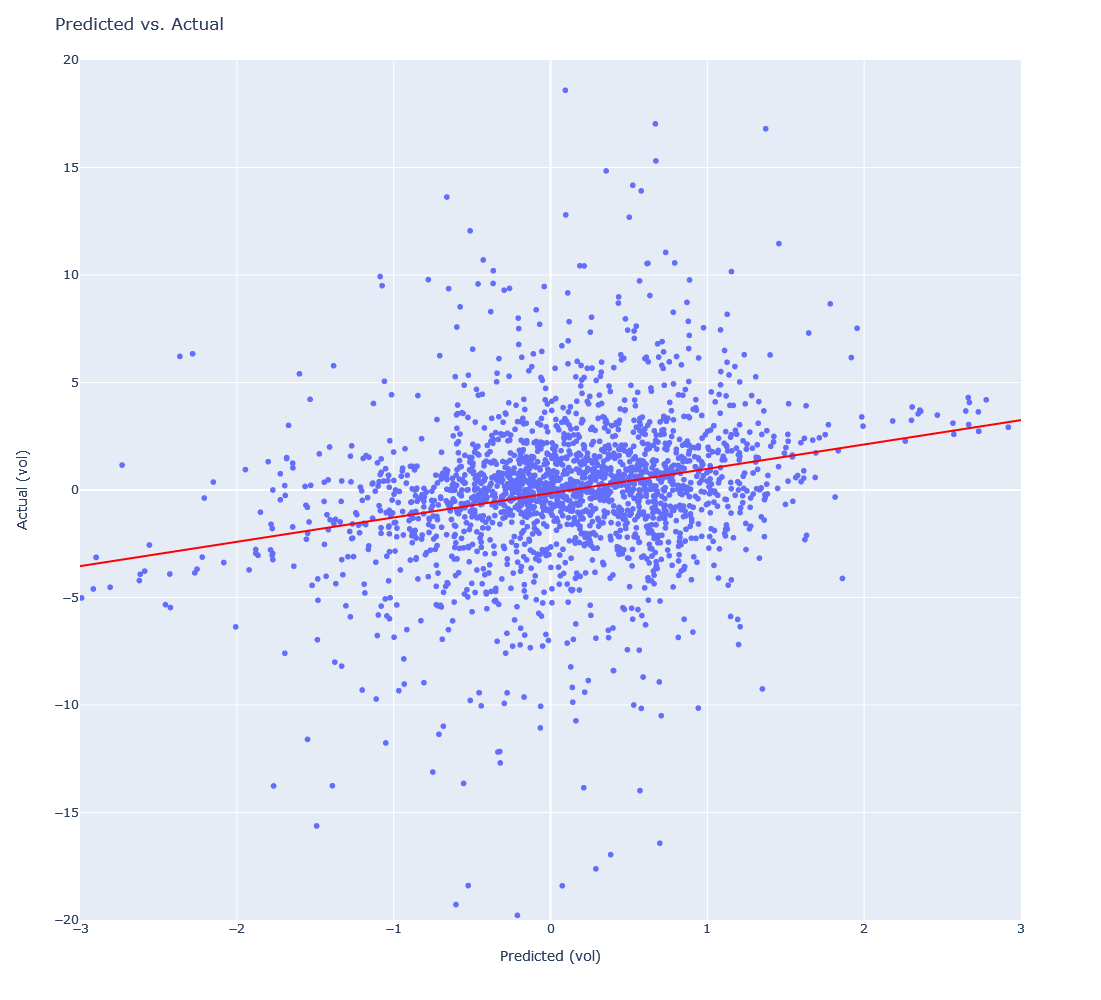

In [24]:
# Show plot of predicted vs actual results for the best grid
fig = px.scatter(x=be.predict(X_test), y=y_test, trendline="ols", \
                 width=1000, height=1000, trendline_color_override="red")
fig.update_layout(
    title="Predicted vs. Actual",
    xaxis_title="Predicted (vol)",
    yaxis_title="Actual (vol)"
)

fig.update_xaxes(range=[-3,3])
fig.update_yaxes(range=[-20,20])
fig.show()

### Attempt 1 Analysis

In our first attempt, we noticed that none of the regressors had a strong correlation with our target variable (vol_score). However, even a small correlation is enough to constitute success. We calculated results for our best grid (RandomForest) to produce calculations and graphs.

Despite the modest gains from the LLM-sourced features, we conclude there is benefit to using the sentiment of earnings calls in isolation to make predictions about the open price of a stock during its next trading interval. 

We discuss action items and next steps in our concluding comments.

## Attempt 2: Include Earnings Surprise Data

Earnings Surprise information is now added to the available features and evaluated for effectiveness. We perform the same analysis as in the first attempt with the new features. This constitutes the maximum publicly available information at the time of the earnings call. 

### Prepare Columns for Testing

In [25]:
# build list of columns to analyze as input variables
#feature_names = ['sentiment', 'negative_1_1', 'positive_1_1', 'neutral_1_1']
feature_names = ['sentiment', 'negative', 'positive', 'neutral', 'eps_act_vol', 'surprise_vol']
column_list = []
for col in stock.columns:
    for feature in feature_names:
        if re.search(feature, col):
        #if feature == col or (re.search('sentiment', col) and re.search('sentiment', feature)):
            column_list.append(col)
column_list       

['surprise_vol',
 'eps_act_vol',
 'sentiment_1_1',
 'positive_1_1',
 'negative_1_1',
 'neutral_1_1',
 'sentiment_1_3',
 'positive_1_3',
 'negative_1_3',
 'neutral_1_3',
 'sentiment_2_3',
 'positive_2_3',
 'negative_2_3',
 'neutral_2_3',
 'sentiment_3_3',
 'positive_3_3',
 'negative_3_3',
 'neutral_3_3',
 'sentiment_1_4',
 'positive_1_4',
 'negative_1_4',
 'neutral_1_4',
 'sentiment_2_4',
 'positive_2_4',
 'negative_2_4',
 'neutral_2_4',
 'sentiment_3_4',
 'positive_3_4',
 'negative_3_4',
 'neutral_3_4',
 'sentiment_4_4',
 'positive_4_4',
 'negative_4_4',
 'neutral_4_4']

In [26]:
# explicit list of numeric/categorical features for different treatment in a pipeline

numeric_features = column_list
categorical_features = []

In [27]:
# use the 'vol_score' column as the target

X, y = stock[column_list], stock['vol_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=342)

### Fit all grids

In [28]:
# gather results for all predictors with given hyperparameters 

#all_results = fit_all_grids(predictors, X_train, y_train, hyperparams, \
#                            n_jobs=5, cv=5, scoring='neg_mean_squared_error', verbose=10)

all_results = fit_all_grids(predictors, X_train, y_train, hyperparams, \
                            n_jobs=8, cv=5, scoring='r2', verbose=10)

Running predictor: LinearRegression

Fitting 5 folds for each of 3 candidates, totalling 15 fits
    cpu  time: 167.5 sec
    wall time: 176.2 sec
----------------------------------------
Running predictor: DecisionTreeRegressor

Fitting 5 folds for each of 9 candidates, totalling 45 fits
    cpu  time: 541.9 sec
    wall time: 403.3 sec
----------------------------------------
Running predictor: RandomForestRegressor

Fitting 5 folds for each of 4 candidates, totalling 20 fits
    cpu  time: 678.9 sec
    wall time: 709.9 sec
----------------------------------------
Running predictor: GradientBoostingRegressor

Fitting 5 folds for each of 2 candidates, totalling 10 fits
    cpu  time: 62.8 sec
    wall time: 76.4 sec
----------------------------------------
Running predictor: KNeighborsRegressor

Fitting 5 folds for each of 4 candidates, totalling 20 fits
    cpu  time: 6.2 sec
    wall time: 4.6 sec
----------------------------------------
Running predictor: Ridge

Fitting 5 folds fo

### Grid Scoring and Parameter Analysis

In [29]:
# analyze results for all fit grids

print('Scoring Results - All Grids')
print('===========================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    be = all_results[i].best_estimator_
    train_mse = mean_squared_error(be.predict(X_train), y_train)
    test_mse = mean_squared_error(be.predict(X_test), y_test)
    train_r2 = be.score(X_train, y_train)
    test_r2 = be.score(X_test, y_test)
    
    print('Train MSE: %f' % train_mse)
    print('Test MSE: %f' % test_mse)
    print('Train R2: %f' % train_r2)
    print('Test R2: %f' % test_r2)
    print()

Scoring Results - All Grids

LinearRegression
Train MSE: 12.595979
Test MSE: 12.733052
Train R2: 0.044363
Test R2: 0.043239

DecisionTreeRegressor
Train MSE: 11.235164
Test MSE: 11.727223
Train R2: 0.147606
Test R2: 0.118817

RandomForestRegressor
Train MSE: 1.387826
Test MSE: 10.480899
Train R2: 0.894708
Test R2: 0.212466

GradientBoostingRegressor
Train MSE: 2.328581
Test MSE: 11.657246
Train R2: 0.823334
Test R2: 0.124075

KNeighborsRegressor
Train MSE: 12.395376
Test MSE: 12.835555
Train R2: 0.059583
Test R2: 0.035537

Ridge
=====
Train MSE: 12.579181
Test MSE: 12.735228
Train R2: 0.045638
Test R2: 0.043076

LinearSVR
Train MSE: 12.687724
Test MSE: 12.904875
Train R2: 0.037403
Test R2: 0.030328

SVR
===
Train MSE: 9.718401
Test MSE: 12.440755
Train R2: 0.262680
Test R2: 0.065202



In [30]:
# print parameters chosen for each grid

print('Parameter Settings - All Grids')
print('==============================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    #print(all_results[i].best_estimator_['predictor'].get_params())
    print(all_results[i].best_params_)
    print()

Parameter Settings - All Grids

LinearRegression
{'sfs__n_features_to_select': 4}

DecisionTreeRegressor
{'predictor__max_depth': 4, 'sfs__n_features_to_select': 4}

RandomForestRegressor
{'predictor__max_features': 4, 'predictor__n_estimators': 4000, 'sfs': 'passthrough'}

GradientBoostingRegressor
{'predictor__max_features': 1, 'predictor__n_estimators': 4000, 'sfs': 'passthrough'}

KNeighborsRegressor
{'predictor__n_neighbors': 80, 'sfs': 'passthrough'}

Ridge
=====
{'predictor__alpha': 599.4842503189409, 'sfs__n_features_to_select': 6}

LinearSVR
{'sfs__n_features_to_select': 6}

SVR
===
{'predictor__gamma': 0.01, 'predictor__kernel': 'rbf', 'sfs': 'passthrough'}



In [31]:
# print features chosen for each grid

print('Feature Names - All Grids')
print('=========================')
print()
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    fn = all_results[i].best_estimator_.named_steps['preprocess'].get_feature_names_out(numeric_features)
    if type(all_results[i].best_estimator_['sfs']) == type(SequentialFeatureSelector(LinearRegression())):
        for feature in all_results[i].best_estimator_['sfs'].get_feature_names_out(fn):
            print(feature)
        #print(all_results[i].best_estimator_['sfs'].get_feature_names_out(fn))
    else:
        print('All polynomial features used (feature count=%d)' % (len(fn),))
    print()

Feature Names - All Grids

LinearRegression
numeric__surprise_vol sentiment_3_4
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

DecisionTreeRegressor
numeric__surprise_vol sentiment_3_4
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

RandomForestRegressor
All polynomial features used (feature count=630)

GradientBoostingRegressor
All polynomial features used (feature count=630)

KNeighborsRegressor
All polynomial features used (feature count=630)

Ridge
=====
numeric__surprise_vol sentiment_3_4
numeric__sentiment_1_1 sentiment_1_4
numeric__positive_1_1 neutral_2_3
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive_2_3 sentiment_1_4

LinearSVR
numeric__surprise_vol sentiment_3_4
numeric__sentiment_1_1 sentiment_1_4
numeric__positive_1_1 neutral_2_3
numeric__negative_1_1 neutral_1_1
numeric__negative_1_1 sentiment_1_3
numeric__positive

In [32]:
# print feature importance for all fit grids

print('Feature Importance - All Grids')
print('==============================')
for i in range(len(all_results)):
    predictor_name = type(predictors[i]).__name__
    print(predictor_name)
    print('='*len(predictor_name))
    
    r = permutation_importance(all_results[i], X_test, y_test, n_repeats=30, n_jobs=8, random_state=32)
    for j in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[j] - 2 * r.importances_std[j] > 0:
            #print(X_test.columns[j])
            print(f"{X_test.columns[j]:<20}"
                f"{r.importances_mean[j]:.3f}"
                f" +/- {r.importances_std[j]:.3f}")
    print()

Feature Importance - All Grids
LinearRegression
negative_1_1        0.061 +/- 0.008
sentiment_1_4       0.010 +/- 0.004
sentiment_1_3       0.006 +/- 0.003

DecisionTreeRegressor
surprise_vol        0.212 +/- 0.048
negative_1_1        0.050 +/- 0.006
neutral_1_1         0.010 +/- 0.005

RandomForestRegressor
surprise_vol        0.223 +/- 0.012
eps_act_vol         0.021 +/- 0.002
negative_1_1        0.013 +/- 0.003
negative_3_4        0.012 +/- 0.001
negative_1_4        0.011 +/- 0.002
negative_2_3        0.011 +/- 0.002
negative_2_4        0.010 +/- 0.001
negative_1_3        0.009 +/- 0.001
positive_4_4        0.005 +/- 0.001
sentiment_1_1       0.005 +/- 0.001
sentiment_2_3       0.005 +/- 0.002
positive_3_3        0.005 +/- 0.001
sentiment_3_3       0.005 +/- 0.001
sentiment_4_4       0.005 +/- 0.001
sentiment_2_4       0.005 +/- 0.001
neutral_1_3         0.005 +/- 0.001
negative_3_3        0.004 +/- 0.001
neutral_2_4         0.004 +/- 0.001
positive_3_4        0.004 +/- 0.001
sentim

### Review Best Grid Results

#### Calculate Available Volatility Gains

In [33]:
# organize results by bin for the best grid (RandomForest)
be = all_results[2].best_estimator_
test_data = pd.DataFrame({'pred': be.predict(X_test), 'actual': y_test})
test_data.sort_values(by=['pred'], inplace=True)
#test_data

In [34]:
bins = [-5, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 5]
print(bins)
test_data['bin'] = pd.cut(test_data['pred'], bins=bins)
#test_data

[-5, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 5]


In [35]:
# show mean result of predictions in bin ranges
labels = test_data['bin'].values.unique()
test_data.groupby('bin')['actual'].mean()

bin
(-5.0, -2.0]   -3.610464
(-2.0, -1.5]   -1.886527
(-1.5, -1.0]   -1.606126
(-1.0, -0.5]   -0.874273
(-0.5, 0.0]    -0.524080
(0.0, 0.5]      0.508101
(0.5, 1.0]      0.648277
(1.0, 1.5]      1.639738
(1.5, 2.0]      1.218898
(2.0, 5.0]      2.998615
Name: actual, dtype: float64

In [36]:
# show count of predictions in bin ranges
test_data.groupby('bin')['actual'].count()

bin
(-5.0, -2.0]    145
(-2.0, -1.5]    110
(-1.5, -1.0]    198
(-1.0, -0.5]    221
(-0.5, 0.0]     327
(0.0, 0.5]      298
(0.5, 1.0]      344
(1.0, 1.5]      281
(1.5, 2.0]      168
(2.0, 5.0]      126
Name: actual, dtype: int64

In [37]:
# calculate volatility gain for the full dataset
test_data = pd.DataFrame({'pred': be.predict(X_test), 'actual': y_test})
test_data['gain'] = test_data.apply(lambda row: (np.sign(row.pred) * row.actual), axis=1)
vol_gain = test_data['gain'].sum()
test_count = test_data['gain'].count()
vol_total = test_data['actual'].abs().sum()

print('volatility gain: %.1f' % (vol_gain,))
print('prediction count: %.1f' % (test_count,))
print('per-prediction gain: %.2f' % ((vol_gain / test_count),))
print()
print('volatility total: %.1f' % (vol_total,))

volatility gain: 2975.5
prediction count: 2237.0
per-prediction gain: 1.33

volatility total: 5378.3


In [38]:
# calculate the volatility gain for high-probability predictions
hp_df = test_data.query('abs(pred) > 1.0')
vol_gain = hp_df['gain'].sum()
test_count = hp_df['gain'].count()
vol_total = hp_df['actual'].abs().sum()

print('volatility gain: %.1f' % (vol_gain,))
print('prediction count: %.1f' % (test_count,))
print('per-prediction gain: %.2f' % ((vol_gain / test_count),))
print()
print('volatility total: %.1f' % (vol_total,))

volatility gain: 2236.5
prediction count: 1047.0
per-prediction gain: 2.14

volatility total: 3126.4


#### Plot Predicted vs. Actual Results

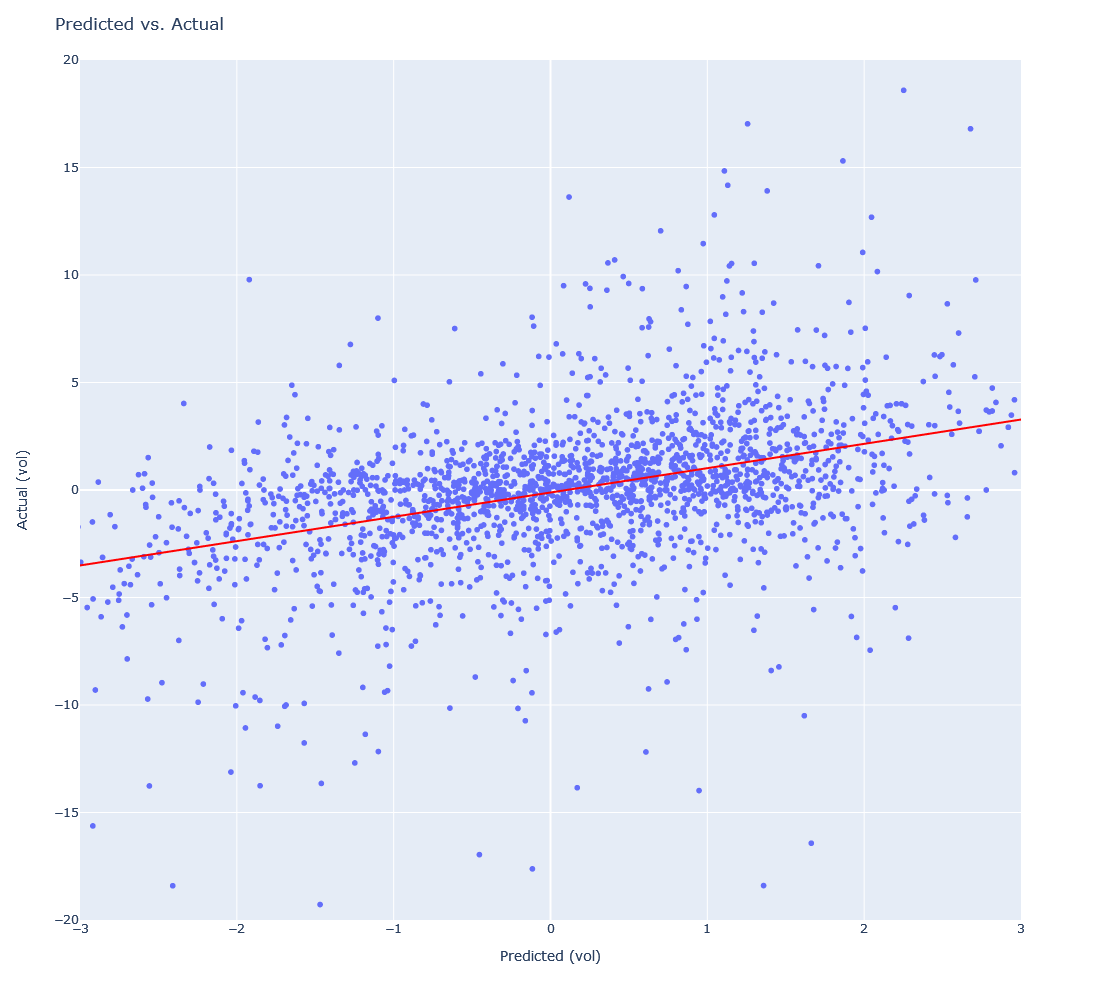

In [39]:
# Show plot of predicted vs actual results for the best grid
fig = px.scatter(x=be.predict(X_test), y=y_test, trendline="ols", \
                 width=1000, height=1000, trendline_color_override="red")
fig.update_layout(
    title="Predicted vs. Actual",
    xaxis_title="Predicted (vol)",
    yaxis_title="Actual (vol)"
)

fig.update_xaxes(range=[-3,3])
fig.update_yaxes(range=[-20,20])
fig.show()

### Attempt 2 Analysis

In our second attempt, we analyzed earnings surprise data alongside the LLM-generated feature data. Our predictions improved significantly as a result. Again, we noticed the RandomForestRegressor had the best results and used that data for our analysis.

Using the test dataset and our best regressor, we were able to capture a per-prediction volatility gain of 1.33 units.  If we restricted the test to higher-probability predictions, we were able to capture 2.14 units. The average volatility move for a stock in a given day is 1.84 units; 2.35 units following earnings calls (both stats found in an earlier notebook). This means our predictions on average show a net gain and correct prediction of approximately 1 day's average price move for the stocks studied. 

## Findings

In this exercise, we set out to determine if sentiment data from earnings calls could constitute a valid prediction for the opening stock price the following morning. In summary, the answer is a very modest yes. Said differently, the data does not lend itself to accurate individual predictions, but in aggregate, sentiment data allows us to make directional predictions with a gain that can be measured. The effect is improved further when we include earnings surprise data.

The combination of earnings surprise data as well as LLM-generated sentiment data allowed an $R^{2}$ score of 0.22 in our best case. This is successful in that it allows us to make good aggregate predictions in a very noisy environment. 

## Next Steps and Recommendations

As with many data problems, any conclusion readily lends itself to a new analysis. In order to further develop the results obtained, we make 3 suggestions for potential improvement:

1. Discovery of additional numeric features in the sentiment data
2. Use of additional LLMs
3. Use of additional ensemble techniques

#### Discovery of additional numeric features
Our LLM was able to generate sentiment data at a sentence level. To simplify analysis, we analyzed sentiment in larger blocks. For example, our variable `sentiment_1_1` refers to the sentiment of the full earnings call, `sentiment_1_4` refers to sentiment of the first quarter of the earnings call, etc.

Additional structure to the earnings call may have been lost in the process. It may be that poor earnings calls have additional structure at a granular level consisting of a known sentiment pattern (eg. compliment sandwich) that portend even more highly negative outcomes. Discovering these features, if they exist, would provide additional gains to our model.

#### Use of additional LLMs
In our case, we only used a single LLM. Use of additional LLMs, particularly those tuned to analyzing financial information, would likely result in further improvement.

#### Use of additional ensemble techniques
We explored a few ensemble techniques in this analysis but our best, Random Forest, only makes use of decision trees. An ensemble technique combining multiple types of estimators may be able to improve this further.